# Figure. CNV eQTL Characteristics

In [1]:
import copy
import cPickle
import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_cnv_eqtl_characteristics'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.

In [2]:
fn = os.path.join(ciepy.root, 'output', 'mcnv_analysis', 'sig.tsv')
mcnv_sig = pd.read_table(fn, index_col=0)

In [3]:
fn = os.path.join(ciepy.root, 'output/cnv_analysis/cnv_gene_variants.pickle')
cnv_gv = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'output/cnv_analysis/combined_info.pickle')
combined_info = cPickle.load(open(fn))

sig_cnvs = set(cnv_gv.cnv_id)
not_sig_cnvs = set(combined_info.index) - sig_cnvs

In [4]:
cnv_lead_vars = cnv_gv[cnv_gv.cnv_is_lead]
cnv_lead_vars = cnv_lead_vars.sort_values(by='pvalue').drop_duplicates(subset=['gene_id'])

In [5]:
p = sum(cnv_lead_vars.beta > 0) / float(cnv_lead_vars.shape[0])
print('{:.2f}% of lead CNV eQTLs are positively associated with gene expression.'.format(p * 100))

84.26% of lead CNV eQTLs are positively associated with gene expression.


In [6]:
sns.set_style('whitegrid')

In [7]:
s,p = stats.mannwhitneyu(np.log10(combined_info.ix[sig_cnvs, 'svlen'].abs()),
                                  np.log10(combined_info.ix[not_sig_cnvs, 'svlen'].abs()))
print('Length of CNV eQTLs vs. CNVs that are not eQTLs is different (p={:.3e}, Mann Whitney U).'.format(p))

Length of CNV eQTLs vs. CNVs that are not eQTLs is different (p=1.074e-75, Mann Whitney U).


In [8]:
s,p = stats.mannwhitneyu(np.log10(combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1),
                         np.log10(combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1))
print('Distance from nearest TSS of CNV eQTLs vs. CNVs that are not eQTLs '
      'is different (p={:.3e}, Mann Whitney U).'.format(p))

Distance from nearest TSS of CNV eQTLs vs. CNVs that are not eQTLs is different (p=9.909e-76, Mann Whitney U).


108 lead CNVs.
Effect sizes for lead CNVs are biased (p=2.075e-13, binomial test).
33 genic mCNV eGenes.
Effect sizes for genic lead mCNVs are biased (p=1.309e-07, binomial test).
57 lead intergenic mCNV eGenes.
Effect sizes for intergenic lead mCNVs are biased (p=3.202e-03, binomial test).


/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


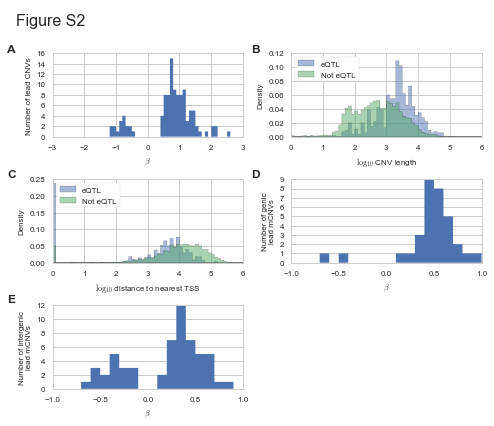

In [9]:
fig = plt.figure(figsize=(6.85, 6), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 0, 'Figure S2',
        size=16, va='bottom')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

gs = gridspec.GridSpec(3, 2)

# Lead CNV effect sizes
ax = fig.add_subplot(gs[0, 0])
bins = np.arange(-3, 3.1, 0.1)
cnv_lead_vars.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled', lw=0)
print('{:,} lead CNVs.'.format(cnv_lead_vars.drop_duplicates('gene_id').shape[0]))
p = stats.binom_test((cnv_lead_vars.drop_duplicates('gene_id').beta > 0).value_counts())
print('Effect sizes for lead CNVs are biased '
      '(p={:.3e}, binomial test).'.format(p))
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of lead CNVs', fontsize=8)
ax.set_xlim(-3, 3)

# Length
ax = fig.add_subplot(gs[0, 1])

se = np.log10(combined_info.ix[sig_cnvs, 'svlen'].abs())
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))

se = np.log10(combined_info.ix[not_sig_cnvs, 'svlen'].abs())
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='Not eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))
ax.legend(fontsize=8, loc='upper left', fancybox=True, frameon=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\log_{10}$ CNV length', fontsize=8)
ax.set_ylabel('Density', fontsize=8)

# TSS distance.
ax = fig.add_subplot(gs[1, 0])

se = np.log10(combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1)
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))

se = np.log10(combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1)
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='Not eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))
ax.legend(fontsize=8, loc='upper left', fancybox=True, frameon=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\log_{10}$ distance to nearest TSS', fontsize=8)
ax.set_ylabel('Density', fontsize=8)

tdf = mcnv_sig.sort_values(by=['overlap_gene_cons', 'pvalue']).drop_duplicates(subset='gene')

# Genic mCNV 
ax = fig.add_subplot(gs[1, 1])
ax.set_ylabel('Number of genic\nlead mCNVs', fontsize=8)
ax.set_xlabel('$\\beta$', fontsize=8)
tdf[tdf.overlap_gene_cons].beta.hist(bins=np.arange(-1, 1.1, 0.1), ax=ax, histtype='stepfilled', lw=0)
ax.grid(axis='x')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
print('{:,} genic mCNV eGenes.'.format(tdf[tdf.overlap_gene_cons].shape[0]))
p = stats.binom_test((tdf[tdf.overlap_gene_cons].beta > 0).value_counts())
print('Effect sizes for genic lead mCNVs are biased '
      '(p={:.3e}, binomial test).'.format(p))

# Intergenic mCNV
ax = fig.add_subplot(gs[2, 0])
tdf[tdf.overlap_gene_cons == False].beta.hist(bins=np.arange(-1, 1.1, 0.1), ax=ax, histtype='stepfilled', lw=0)
ax.set_ylabel('Number of intergenic\nlead mCNVs', fontsize=8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.grid(axis='x')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
p = stats.binom_test((tdf[tdf.overlap_gene_cons == False].beta > 0).value_counts())
print('{:,} lead intergenic mCNV eGenes.'.format(tdf[tdf.overlap_gene_cons == False].shape[0]))
print('Effect sizes for intergenic lead mCNVs are biased '
      '(p={:.3e}, binomial test).'.format(p))

t = fig.text(0.005, 0.87, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.87, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.58, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.58, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.29, 'E', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig(os.path.join(outdir, 'cnv_eqtl_chars.pdf'))
fig.savefig(os.path.join(outdir, 'cnv_eqtl_chars.png'), dpi=300)

108 lead CNVs.
Effect sizes for lead CNVs are biased (p=2.075e-13, binomial test).
33 genic mCNV eGenes.
Effect sizes for genic lead mCNVs are biased (p=1.309e-07, binomial test).
57 lead intergenic mCNV eGenes.
Effect sizes for intergenic lead mCNVs are biased (p=3.202e-03, binomial test).


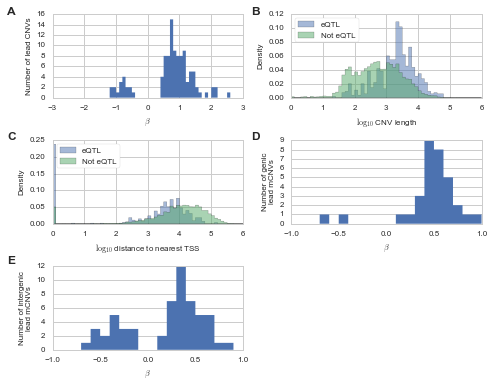

In [14]:
fig = plt.figure(figsize=(6.85, 5.4), dpi=300)

gs = gridspec.GridSpec(3, 2)

# Lead CNV effect sizes
ax = fig.add_subplot(gs[0, 0])
bins = np.arange(-3, 3.1, 0.1)
cnv_lead_vars.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled', lw=0)
print('{:,} lead CNVs.'.format(cnv_lead_vars.drop_duplicates('gene_id').shape[0]))
p = stats.binom_test((cnv_lead_vars.drop_duplicates('gene_id').beta > 0).value_counts())
print('Effect sizes for lead CNVs are biased '
      '(p={:.3e}, binomial test).'.format(p))
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of lead CNVs', fontsize=8)
ax.set_xlim(-3, 3)

# Length
ax = fig.add_subplot(gs[0, 1])

se = np.log10(combined_info.ix[sig_cnvs, 'svlen'].abs())
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))

se = np.log10(combined_info.ix[not_sig_cnvs, 'svlen'].abs())
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='Not eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))
ax.legend(fontsize=8, loc='upper left', fancybox=True, frameon=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\log_{10}$ CNV length', fontsize=8)
ax.set_ylabel('Density', fontsize=8)

# TSS distance.
ax = fig.add_subplot(gs[1, 0])

se = np.log10(combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1)
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))

se = np.log10(combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1)
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='Not eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))
ax.legend(fontsize=8, loc='upper left', fancybox=True, frameon=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\log_{10}$ distance to nearest TSS', fontsize=8)
ax.set_ylabel('Density', fontsize=8)

tdf = mcnv_sig.sort_values(by=['overlap_gene_cons', 'pvalue']).drop_duplicates(subset='gene')

# Genic mCNV 
ax = fig.add_subplot(gs[1, 1])
ax.set_ylabel('Number of genic\nlead mCNVs', fontsize=8)
ax.set_xlabel('$\\beta$', fontsize=8)
tdf[tdf.overlap_gene_cons].beta.hist(bins=np.arange(-1, 1.1, 0.1), ax=ax, histtype='stepfilled', lw=0)
ax.grid(axis='x')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
print('{:,} genic mCNV eGenes.'.format(tdf[tdf.overlap_gene_cons].shape[0]))
p = stats.binom_test((tdf[tdf.overlap_gene_cons].beta > 0).value_counts())
print('Effect sizes for genic lead mCNVs are biased '
      '(p={:.3e}, binomial test).'.format(p))

# Intergenic mCNV
ax = fig.add_subplot(gs[2, 0])
tdf[tdf.overlap_gene_cons == False].beta.hist(bins=np.arange(-1, 1.1, 0.1), ax=ax, histtype='stepfilled', lw=0)
ax.set_ylabel('Number of intergenic\nlead mCNVs', fontsize=8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.grid(axis='x')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
p = stats.binom_test((tdf[tdf.overlap_gene_cons == False].beta > 0).value_counts())
print('{:,} lead intergenic mCNV eGenes.'.format(tdf[tdf.overlap_gene_cons == False].shape[0]))
print('Effect sizes for intergenic lead mCNVs are biased '
      '(p={:.3e}, binomial test).'.format(p))

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.64, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.64, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.32, 'E', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])

fig.savefig(os.path.join(outdir, 'cnv_eqtl_chars_no_label.pdf'))
fig.savefig(os.path.join(outdir, 'cnv_eqtl_chars_no_label.png'), dpi=300)